### Pytorch - classifier
- 목표: CNN을 활용한 모델을 만들어서 MNIST에 대하여 정확도 95% 이상의 Classifier를 만들기

In [ ]:
from matplotlib import pyplot as plt
import torch

from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' # don't care about this

# seed 고정 - 여러번 실행해도 같은 결과가 나오도록 설정
torch.manual_seed(0)

#### Dataset download

In [ ]:
# train 파라미터는 MINIST 데이터셋에서 train 데이터를 불러올지, test 데이터를 불러올지 결정.
# transform은 아래코드에서 tensor로 변형을 선택하고 있지만, 이미지 크기 조정, 랜덤하게 잘라내거나 회전시키는 등의 변형을 토해 데이터 증강 수행도 가능함.
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
)
dataloader_train = DataLoader(train_data,
                              batch_size=16,
                              shuffle=True)

test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)
dataloader_test = DataLoader(test_data,
                              batch_size=16,
                              shuffle=True)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:10<00:00, 902620.58it/s] 


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 64307.97it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1273754.84it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3899801.18it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



#### Check images

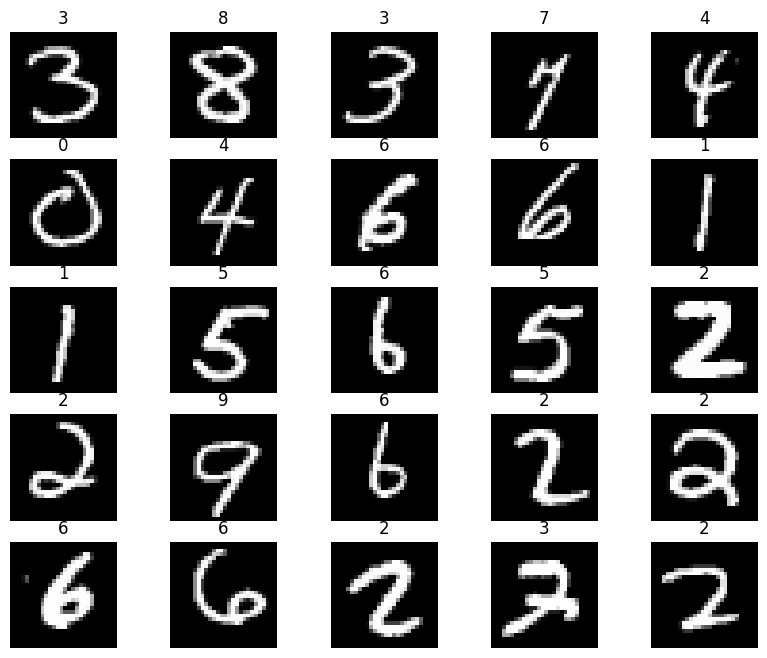

Data shape: torch.Size([1, 28, 28])


In [ ]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    # .item()은 텐서에서 값을 추출하여 Python 숫자로 변환
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    # squeeze()는 차원의 크기가 1인 차원을 제거.
    # MINST 데이터셋은 이미 흑백이기 때문에 (채널, 높이, 너비)의 차원형태에서 채널의 차원 크기가 1임. 따라서 채널 차원을 제거한 2차원 텐서로 변형.
    plt.imshow(img.squeeze(), cmap="gray") # For MNIST dataset
plt.show()
print('Data shape:', img.shape)

#### CNN

In [ ]:
# dataset.MNIST()는 입력이미지를 28*28의 크기로 가져옴
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # fully connected layer, output 10 classes
        # 32 * 7 * 7 : conv2의 출력 채널 수 * 피쳐맵의 높이 * 피쳐맵의 너비, 10: 완전 연결층(out)의 출력 뉴런수(클래스 수)
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        # conv2d의 출력 텐서는 (batch_size, 32, 7, 7)인 상태이나, self.out은 (batch_size, 출력 채널 수 * 피쳐맵의 높이 * 피쳐맵의 너비)값을 입력 받기 때문에
        # view()를 통해 batch_size는 유지하고 나머지 차원들을 모두 곱함.
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output   # return x for visualization

#### Train : GPU 사용X

In [ ]:
# Initialize model and move the model to GPU memory
cnn = CNN()

# Define the loss function
loss_func = nn.CrossEntropyLoss()

# Define the optimizer again
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)

In [ ]:
import time

cnn = CNN()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)

# Train the model
num_epochs = 3 # MNIST dataset을 세 번 반복하여 학습
cnn.train()

start = time.time()
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(dataloader_train):
        # Inference
        output = cnn(images)

        # Calculate loss
        loss = loss_func(output, labels)

        # clear gradients for this training step
        # 기울기 초기화, 각 배치에서 기울기를 통해 가중치 업데이트가 되므로, 가중치는 전단계의 기울기를 초기화 시켜야함.
        optimizer.zero_grad()

        # backpropagation, compute gradients
        loss.backward()
        # apply gradients
        optimizer.step()

        if (i+1) % 500 == 0:
            print ('Epoch [{}/{}], Step [{}], Loss: {:.4f}'
                   .format(epoch + 1, num_epochs, i + 1, loss.item()))

elapsed_time = time.time()-start
print(f"elapsed time : {elapsed_time} sec")

Epoch [1/3], Step [500], Loss: 0.1311
Epoch [1/3], Step [1000], Loss: 0.3413
Epoch [1/3], Step [1500], Loss: 0.2159
Epoch [1/3], Step [2000], Loss: 0.0190
Epoch [1/3], Step [2500], Loss: 0.2649
Epoch [1/3], Step [3000], Loss: 0.2226
Epoch [1/3], Step [3500], Loss: 0.3003
Epoch [2/3], Step [500], Loss: 0.0074
Epoch [2/3], Step [1000], Loss: 0.5671
Epoch [2/3], Step [1500], Loss: 0.2744
Epoch [2/3], Step [2000], Loss: 0.1957
Epoch [2/3], Step [2500], Loss: 0.0570
Epoch [2/3], Step [3000], Loss: 0.0658
Epoch [2/3], Step [3500], Loss: 0.0019
Epoch [3/3], Step [500], Loss: 0.0083
Epoch [3/3], Step [1000], Loss: 0.0533
Epoch [3/3], Step [1500], Loss: 0.2787
Epoch [3/3], Step [2000], Loss: 0.2458
Epoch [3/3], Step [2500], Loss: 0.0082
Epoch [3/3], Step [3000], Loss: 0.0406
Epoch [3/3], Step [3500], Loss: 0.1034
elapsed time : 133.36736297607422 sec


#### Test

In [ ]:
cnn.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in dataloader_test:
        # Inference
        test_output = cnn(images)

        # Calculate error
        # max 를 통해 가장 확률이 높은 숫자를 선택
        pred_y = torch.max(test_output, 1)[1].data.squeeze()
        # 가장 확률이 높은 숫자인 pred_y와 label이 같으면 정답 - 정답인 개수 확인
        correct += (pred_y == labels).sum().item()
        total += labels.size(0)
    accuracy = correct / total * 100

print('Test Accuracy of the model on the 10000 test images: %.2f Percent' % accuracy)

Test Accuracy of the model on the 10000 test images: 96.13 Percent


#### GPU Acceleration

In [ ]:
# Initialize model and move the model to GPU memory
cnn = CNN().cuda()

# Define the loss function : 교차 엔트로피
loss_func = nn.CrossEntropyLoss()

# Define the optimizer again
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)

In [ ]:
import time

cnn = CNN().cuda()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)

# Train the model
num_epochs = 3 # MNIST dataset을 세 번 반복하여 학습
cnn.train()

start = time.time()
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(dataloader_train):
        # Move data to GPU memory
        images = images.cuda()
        labels = labels.cuda()

        # Inference
        output = cnn(images)

        # Calculate loss
        loss = loss_func(output, labels)

        # clear gradients for this training step
        optimizer.zero_grad()

        # backpropagation, compute gradients
        loss.backward()
        # apply gradients
        optimizer.step()

        if (i+1) % 500 == 0:
            print ('Epoch [{}/{}], Step [{}], Loss: {:.4f}'
                   .format(epoch + 1, num_epochs, i + 1, loss.item()))

elapsed_time = time.time()-start
print(f"elapsed time : {elapsed_time} sec")

Epoch [1/3], Step [500], Loss: 0.1303
Epoch [1/3], Step [1000], Loss: 0.0971
Epoch [1/3], Step [1500], Loss: 0.0183
Epoch [1/3], Step [2000], Loss: 0.0074
Epoch [1/3], Step [2500], Loss: 0.1111
Epoch [1/3], Step [3000], Loss: 0.0034
Epoch [1/3], Step [3500], Loss: 0.1973
Epoch [2/3], Step [500], Loss: 0.0016
Epoch [2/3], Step [1000], Loss: 0.0041
Epoch [2/3], Step [1500], Loss: 0.0061
Epoch [2/3], Step [2000], Loss: 0.0252
Epoch [2/3], Step [2500], Loss: 0.1934
Epoch [2/3], Step [3000], Loss: 0.0323
Epoch [2/3], Step [3500], Loss: 0.0173
Epoch [3/3], Step [500], Loss: 0.0044
Epoch [3/3], Step [1000], Loss: 0.0810
Epoch [3/3], Step [1500], Loss: 0.0038
Epoch [3/3], Step [2000], Loss: 0.0070
Epoch [3/3], Step [2500], Loss: 0.4506
Epoch [3/3], Step [3000], Loss: 0.0003
Epoch [3/3], Step [3500], Loss: 0.0016
elapsed time : 51.587924003601074 sec


In [ ]:
cnn.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in dataloader_test:
        # Move data to GPU memory
        images = images.cuda()
        labels = labels.cuda()

        # Inference
        test_output = cnn(images)

        # Calculate error
        pred_y = torch.max(test_output, 1)[1].data.squeeze() # max 를 통해 가장 확률이 높은 숫자를 선택
        correct += (pred_y == labels).sum().item() # 가장 확률이 높은 숫자인 pred_y와 label이 같으면 정답 - 정답인 개수 확인
        total += labels.size(0)
    accuracy = correct / total * 100

print('Test Accuracy of the model on the 10000 test images: %.2f Percent' % accuracy)

Test Accuracy of the model on the 10000 test images: 96.10 Percent


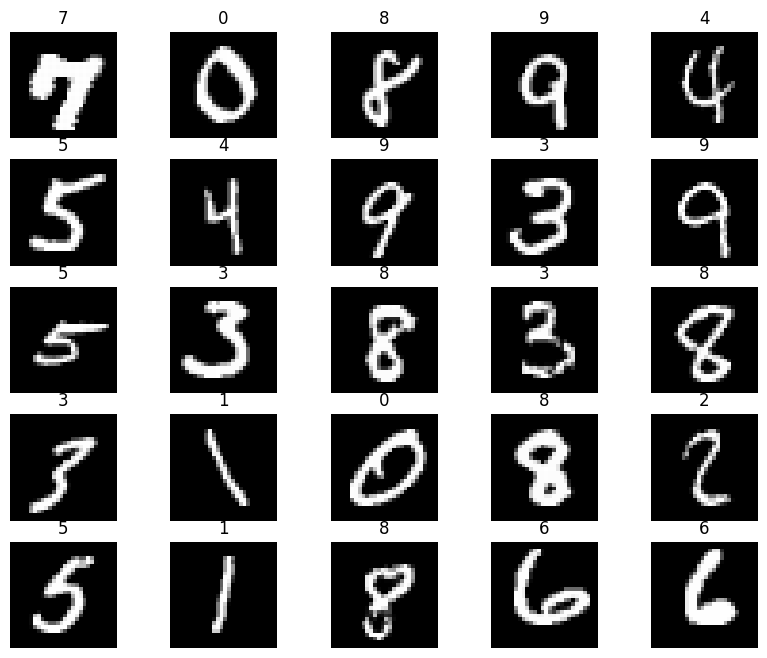

Data shape: torch.Size([1, 28, 28])


In [ ]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()
print('Data shape:', img.shape)